In [193]:
import pandas as pd
import numpy as np

%matplotlib inline

Use "tags" in a modified sdf file to have somewhat more readable variable names, for example,

In [143]:
! head tags

In [144]:
columns = {}
for line in open("tags"):
    line = line.strip()
    if not line[101:].count(" "): continue
    spline = line.split()
    k = spline[0].replace(".", "")
    v = spline[-1]
    columns[k] = v

Load the data and use the tags to rename the columns.

In [145]:
df = pd.read_csv("mw1.csv")
df.rename(columns = columns, inplace = True)
# sorted(list(df.columns))

Check for any duplicate columns.

In [146]:
b = {}
for x in list(df.columns):
    if x in b: print(x)
    b[x] = "a"

In [147]:
df = df[list(columns.values())].copy(deep = True)
df.set_index("ID1967", inplace = True)

In [148]:
df["RACE1967_LABEL"] = df.RACE1967.replace({2:"Black", 1:"White", 3:"Other"})

df["RACE1995"] = None
df.loc[df.RACE1995_BLACK == 0, "RACE1995"] = "OTHER"
df.loc[(df.filter(regex = "RACE1995_", axis = 1) ==1 ).any(axis = 1), "RACE1995"] = "HISPANIC"
df.loc[df.RACE1995_BLACK == 1, "RACE1995"] = "BLACK"

In [149]:
df.loc[df.MOB1967 < 0, "MOB1967"] = 6
df["DOB1967"] = pd.to_datetime(((df.YOB1967 + 1900)*10000 + df.MOB1967 * 100 + 15).astype(str), format='%Y%m%d', errors='coerce')
df["SSAMATCH2003_DOD"] = pd.to_datetime(((df.SSAMATCH2003_YOD)*10000 + df.SSAMATCH2003_MOD * 100 + 15).astype(str), format='%Y%m%d', errors='coerce')
df["SSAMATCH2003_AGE"] = (df.SSAMATCH2003_DOD - df.DOB1967).astype('timedelta64[D]')/365.25
df["NDIMATCH2011_YOD"] = 1900 + df.YOB1967 + df.NDIMATCH2011_AGE
df["SSAMATCH2011_YOD"] = 1900 + df.YOB1967 + df.SSAMATCH2011_AGE
df.loc[(df.YOB1967 < 0) | (df.NDIMATCH2011_AGE < 0), "NDIMATCH2011_YOD"] = -4
df.loc[(df.YOB1967 < 0) | (df.SSAMATCH2011_AGE < 0), "SSAMATCH2011_YOD"] = -4

In [197]:
df["SSAMATCH2003_MATCHED"] = df["SSAMATCH2003_YOD"] > 0
df["NDIMATCH2011_MATCHED"] = df["NDIMATCH2011_AGE"] > 0
df["SSAMATCH2011_MATCHED"] = df["SSAMATCH2011_AGE"] > 0

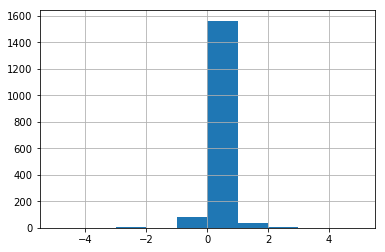

In [150]:
sel = (df["SSAMATCH2011_AGE"] > 0) & (df["NDIMATCH2011_AGE"] > 0)
(df.loc[sel, "SSAMATCH2011_AGE"] - df.loc[sel, "NDIMATCH2011_AGE"]).hist(bins = range(-5, 6))

### I really don't get this -- year after year, the total (5083) equals valid skip + 2 × noninterview.  Why?
```
R05284.00    [CV]                                           Survey Year: 1982
  PRIMARY VARIABLE


             REASON FOR NONINTERVIEW IN 82

REASON

       1       1 UNABLE TO CONTACT - REASON UNSPECIFIED
       1       2 MOVER (GOOD ADDRESS) INTERVIEW IMPOSSIBLE:DISTANCE TOO GREAT
       2       3 MOVER (GOOD ADDRESS) UNABLE TO INTERVIEW AFTER REPEATED
                      ATTEMPTS
      14       4 MOVER (NO GOOD ADDRESS)
      10       5 NONMOVER - UNABLE TO INTERVIEW AFTER REPEATED ATTEMPTS
       8       6 TEMPORARILY ABSENT
       0       7 IN ARMED FORCES
       4       8 INSTITUTIONALIZED
    1061       9 REFUSED
     238      10 DECEASED
       5      11 OTHER
     193      12 NON-INTERVIEW TWO YEARS, RESPONDENT DROPPED FROM SAMPLE
       4      13 MOVED OUTSIDE U.S. (OTHER THAN ARMED FORCES)
  -------
    1541

Refusal(-1)            0
Don't Know(-2)         0
TOTAL =========>    1541   VALID SKIP(-4)    2001     NON-INTERVIEW(-5)    1541
```

In [151]:
print("The total number of respondents is:", df.shape[0])
print("The total zero-weights equals the number of non-interviews:", (df.W1982 == 0).sum())
print("By the way, the sums are just a coincidence??", 1541+2001, 2*1541+2001)
print("But the non-interviews are set to -4 (cdb says it should be 2001) (?):", (df.NONINT1982 == -5).sum(), (df.NONINT1982 == -4).sum())
print("And one cannot separate them by requiring nonzero weight:", ((df.NONINT1982 == -4) & (df.W1982 == 0)).sum())
print("But if I count them up, I'm not sure how to separate these.  The weights are all non-zero:", (df.W1982 > 0).sum())
print("So who are these other 1541 people, and what happened to them??")

The total number of respondents is: 5083
The total zero-weights equals the number of non-interviews: 1541
By the way, the sums are just a coincidence?? 3542 5083
But the non-interviews are set to -4 (cdb says it should be 2001) (?): 0 3542
And one cannot separate them by requiring nonzero weight: 0
But if I count them up, I'm not sure how to separate these.  The weights are all non-zero: 3542
So who are these other 1541 people, and what happened to them??


In [152]:
! # I am not crazy.
! cat mw1.csv | cut -f113 -d, | sort | uniq -c

      1 1
    238 10
      5 11
    193 12
      4 13
      1 2
      2 3
     14 4
   3542 -4
     10 5
      8 6
      4 8
   1061 9
      1 "R0528400"


So in short, is valid skip for non-interview an interview, or a different sort of skip??

In [153]:
df.loc[(df.W1982 >= 0) & (df.HP1982_WALKING > -5), ["NONINT1982", "W1982"]].groupby("NONINT1982").count()

,W1982
NONINT1982,
-4,3542


In [154]:
df.loc[(df.W1982 >= 0) & (df.HP1982_WALKING > -5), ["NONINT1982", "W1982"]].groupby("NONINT1982").count()

,W1982
NONINT1982,
-4,3542


Let's look for three cases:
1. interview after a death date (I > D),
2. death after non-interview due to death (D>NI), and
3. no death record after non-interview due to death (NR, fraction).

In [155]:
pd.options.display.max_columns = 1000
nonint_years = sorted([int(y[6:]) for y in list(df.filter(regex = "NONINT[0-9]{4}$").columns)])
for y in nonint_years:
    df["NONINT{}_ALIVE".format(y)]    = df["NONINT{}".format(y)] == -4
    df["NONINT{}_DECEASED".format(y)] = df["NONINT{}".format(y)] == 10

In [174]:
ssa03A, ndi11A, ssa11A = {}, {}, {}
ssa03D, ndi11D, ssa11D = {}, {}, {} 
ssa03NR, ndi11NR, ssa11NR = {}, {}, {} 
for y in nonint_years:
    va = "NONINT" + str(y) + "_ALIVE"
    vd = "NONINT" + str(y) + "_DECEASED"
    ssa03A[y]  = (df[va] & (df.SSAMATCH2003_YOD > 0) & (df.SSAMATCH2003_YOD < y-2)).sum()
    ndi11A[y]  = (df[va] & (df.NDIMATCH2011_YOD > 0) & (df.NDIMATCH2011_YOD < y-2)).sum()
    ssa11A[y]  = (df[va] & (df.SSAMATCH2011_YOD > 0) & (df.SSAMATCH2011_YOD < y-2)).sum()
    ssa03D[y]  = (df[vd] & (df.SSAMATCH2003_YOD > 0) & (df.SSAMATCH2003_YOD > y+2)).sum()
    ndi11D[y]  = (df[vd] & (df.NDIMATCH2011_YOD > 0) & (df.NDIMATCH2011_YOD > y+2)).sum()
    ssa11D[y]  = (df[vd] & (df.SSAMATCH2011_YOD > 0) & (df.SSAMATCH2011_YOD > y+2)).sum()

    ssa03NR[y] = (df[vd] & (df.SSAMATCH2003_YOD < 0)).sum() / df[vd].sum()
    ndi11NR[y] = (df[vd] & (df.NDIMATCH2011_AGE < 0)).sum() / df[vd].sum()
    ssa11NR[y] = (df[vd] & (df.SSAMATCH2011_AGE < 0)).sum() / df[vd].sum()

pd.DataFrame({"SSA03 I>D"  : ssa03A,  "NDI11 I>D"  : ndi11A,  "SSA11 I>D"  : ssa11A,
              "SSA03 D>NI" : ssa03D,  "NDI11 D>NI" : ndi11D,  "SSA11 D>NI" : ssa11D,
              "SSA03 NR"   : ssa03NR, "NDI11 NR"   : ndi11NR, "SSA11 NR"   : ssa11NR})

,NDI11 D>NI,NDI11 I>D,NDI11 NR,SSA03 D>NI,SSA03 I>D,SSA03 NR,SSA11 D>NI,SSA11 I>D,SSA11 NR
1968,2,0,0.727273,0,0,0.727273,1,1,0.681818
1969,2,0,0.742857,0,0,0.742857,1,1,0.714286
1971,3,0,0.716667,2,0,0.716667,3,1,0.700000
1972,3,0,0.722222,2,0,0.708333,3,1,0.694444
1974,4,0,0.603960,3,0,0.594059,4,1,0.623762
1976,5,0,0.564885,3,0,0.557252,4,1,0.603053
1977,6,0,0.550000,4,0,0.542857,5,1,0.585714
1979,6,0,0.488636,4,0,0.482955,6,1,0.522727
1981,9,0,0.412037,4,0,0.439815,7,1,0.472222
1982,9,1,0.378151,4,0,0.420168,7,1,0.457983


RACE1967_LABEL
Black    Axes(0.125,0.125;0.775x0.755)
Other    Axes(0.125,0.125;0.775x0.755)
White    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

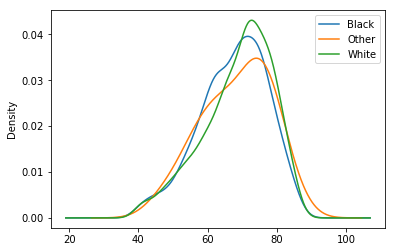

In [17]:
df[df.NDIMATCH2011_AGE > 30].groupby("RACE1967_LABEL").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

RACE1995
BLACK       Axes(0.125,0.125;0.775x0.755)
HISPANIC    Axes(0.125,0.125;0.775x0.755)
OTHER       Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

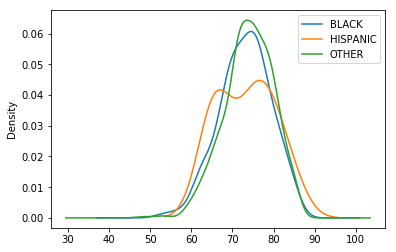

In [18]:
df[~df.RACE1995.isnull() & (df.NDIMATCH2011_AGE > 0)].groupby("RACE1995").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

In [20]:
for y in [1971, 1972, 1984, 1986]:
    v = "HL" + str(y)NDIMATCH2011_AGE
    df[v] = ""
    df.loc[(df.filter(regex = "^{}_.*".format(v)) > -5).any(axis = 1), v] = "Not Limited"
    df.loc[(df.filter(regex = "^{}_.*".format(v)) >  0).any(axis = 1), v] = "Limited"

HL1971
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

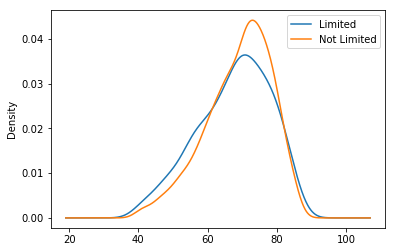

In [21]:
df[df.HL1971.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1971").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

HL1972
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

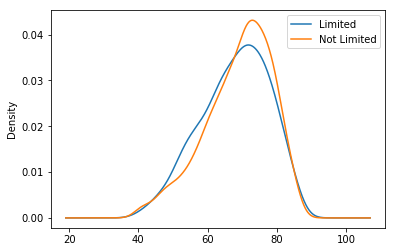

In [22]:
df[df.HL1972.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1972").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

HL1984
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

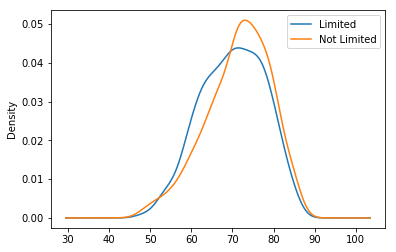

In [23]:
df[df.HL1984.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1984").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

HL1986
Limited        Axes(0.125,0.125;0.775x0.755)
Not Limited    Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

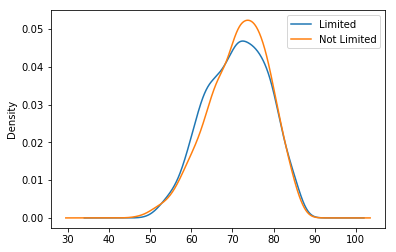

In [24]:
df[df.HL1986.astype(bool) & (df.NDIMATCH2011_AGE > 30)].groupby("HL1986").NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

MARSTAT1967
No Spouse Present    Axes(0.125,0.125;0.775x0.755)
Spouse Present       Axes(0.125,0.125;0.775x0.755)
Name: NDIMATCH2011_AGE, dtype: object

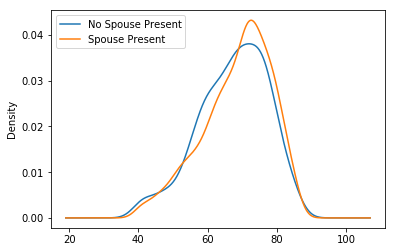

In [32]:
df[(df.NDIMATCH2011_AGE > 0)].replace({"MARSTAT1967" : {1 : "Spouse Present",
                                                        2 : "No Spouse Present",
                                                        3 : "No Spouse Present",
                                                        4 : "No Spouse Present",
                                                        5 : "No Spouse Present",
                                                        6 : "No Spouse Present"}})\
                             .groupby("MARSTAT1967")\
                             .NDIMATCH2011_AGE.plot(kind = "kde", legend = True)

Now let's check match rates along racial & ethnic lines.

In [196]:
pd.pivot_table(df[["RACE1967_LABEL", "SSAMATCH2003_MATCHED", "NDIMATCH2011_MATCHED", "SSAMATCH2011_MATCHED"]], 
               columns = ["RACE1967_LABEL"], aggfunc = np.mean)

RACE1967_LABEL,Black,Other,White
NDIMATCH2011_MATCHED,0.469784,0.356322,0.370771
SSAMATCH2003_MATCHED,0.290647,0.183908,0.207709
SSAMATCH2011_MATCHED,0.434532,0.275862,0.364670
